# AN INTRODUCTION TO QUANTUM COMPUTING IN 2021


Hello and welcome to this quantum computing tutorial! This tutorial has been thought as a q-extra for Física Cuántica II, a course happening at Autonomous University of Barcelona. 

The tutorial consists on two parts: the first part is self-contained, and explores the world of quantum circuits by considering a 1-qubit problem. Next, we move to the second part of the tutorial, to consider PennyLane, which on top of being the name of a beautiful song, it is also the name of a software library dedicated to quantum machine learning.

In Física Cuántica 2 we study variational methods to approximate ground states of hamiltonians. This very well-known technique, is the basis of on of the most prominent quantum algorithms in the so-called NISQ era (i.e. now), which is the Variational Quantum Eigensolver. Here, one consider as ansatz a parametrized quantum circuit, which can potentially be prepared in the lab using small quantum computers (those ones exist nowadays, and despite being quite noisy, they do actually work!). The parameters of thiese quantum circuits are controlled by a classical machine learning agent (say, an algorithm like that one of Instagram, which instead of deciding which photo to show you in the feed section, it decides which kind of unitary the quantum circuit will prepare). Hence, the quantum computer is used to estimate expected values of quantum observables, and the overall objective is to find a configuration of that quantum computer such that a given <i> cost function </i> attains its minimum (for instance, the cost function in the VQE algorithm is the energy of the system).

We really hope you enjoy this tutorial, and feel free to ask any questions! :) 

# Part 1: Castellers

We will work with a 1-qubit (spin 1/2 system) Hamiltonian which is $\hat{H} = \sigma_x =: X$. 

We consider a very simple <b>parametrized quantum circuit </b> (PQC), composed of two rotations aronud the y-axis and z-axis respectively (with angles $\theta, \phi$ respectively) This can be illustrated in the circuit below, which should be read from left to right:

<img src="figures/1qubit_circuit.png">

The result of the unitary transformation generated by this circuit, and applied to the state $|0> = | \uparrow\rangle$ is

\begin{equation}
|\psi \rangle = \cos{\frac{\theta}{2}}|0 \rangle + \sin{\frac{\theta}{2} } e^{ i \phi}|1 \rangle,
\end{equation}

with $\theta \in [0, \pi]$ and $\phi \in [0, 2 \pi)$. The question is: <b>which angles do we choose, such that we can prepare the ground state of H?</b>


<p>This problem is very simple, and it takes three lines to be solved with pen-and-paper. Hence, it's a good starting point to understand how quantum computers can be used to tackle problems of this kind (some of which are not that easy to be solved in pen-and-paper, nor even numerically using the best supercomputers on Earth). We will use a <b> variational quantum algorithm </b> to solve this problem.</p>

<p>Because this is just 1-qubit, we can quickly write a script that simulates the behaviour of the quantum computer (the action of gates, state-preparation, measurement, and energy estimation). For more sophisticated problems, one would typically use quantum-computing libraries such as Qiskit, TensorFlowQuantum, PennyLane, Q#, etc.</p>


## A home-made library

<p> We wrote a tiny script named Castellers, in honor of this risky yet super cool Catalan tradition that consists of making human castles. Similarly, our script can be thought of a program-castle. At the very bottom we have the definitions of the circuit, state preparation, measurements, etc.. At the top we have the energy obtained by the prepared state, as computed by averaging over many outcomes coming from different experiment repetitions.</p>

<p>As explained in the introduction, Variational Quantum Algorithms consist on having a (classical) optimization routine on top of the quantum measurements, which collects the value of the (measured) energy and proposes new values for $(\theta, \phi)$. Iterating the procedure of measuring energy and proposing new parameters, the optimization routine will hopefully find the optimal parameters (those which minimize the energy). <b> This can be thought as an error mitigation technique, were <i>quantum resources</i> are only used to measure expected values.</p>

#### Some comments on the code    

<p>In the code below, we define the $\texttt{QuantumCircuit()}$ object. It contains the properties of quantum circuits that are useful for us (feel free to check it out!). For example, the PQC may consist on first rotating the initial state (which is ussually assumed to be $|0\rangle$) around the $y-axis$, and then rotating the resulting state around the $z$-axis, as depicted in the circuit shwon above. To get the unitary transformation representing this circuit, we use the function $\texttt{unitary(circuit)}$, where $\texttt{circuit}$ is a list that indicates which gates should be applied to the initial states (in the right order); in our example these are the two rotations, which are obtained as yet another functions $\texttt{qc.ry(th), qc.rz(phi)}$.</p>

<p>To get the quantum state output by the circuit (written in the <i> computational basis </i>, which is the basis of $|0\rangle$ and $|1\rangle$), we use the method $\texttt{qc.output_state(unitary)}$.</p>

<p>Finally, we would like to measure the mean value of our Hamiltonian using the prepared state. Note that whereas it is straightforward to measure $\sigma_z$ and its mean value (since we have the state written in the basis that diagonalize that operator), we should perform a change of basis in order to measure other operators (such as $\sigma_x$ $\sigma_y$). For instance, if we wanted to measure $\sigma_x$, a <i>Haddamard</i> should be appended at the end of the circuit, and then we can just measure on the computational basis in order to estimate the energy (this is yet another good excersise to do).</p>


# Castellers code

In what follows, we will import the code from castellers. You don't really need to read the scripts, so feel free to skip this lines. <b>You should run this cells </b> because you will later use the defined functions.

In [1]:
import numpy as np

class QuantumCircuit:
    def __init__(self, n_qubits=1):
        self.n_qubits = n_qubits

    def rz(self,th):
        """
        Comment: we add some phase here (equivalent to yet a second rotation around z-axis of value -th, i.e. Exp[- \ii \theta \Sigma_z /2]), such that Rz(phi)|0> = |0>
        """
        return np.array([[1,0],[0,np.exp(-th*1j)]])
        ##without the phase substraction, MatrixExp(pauliZ) is.
        #return np.array([[np.exp(th*0.5j),0],[0,np.exp(-th*0.5j)]])


    def ry(self,th):
        return np.array([[np.cos(th/2),-np.sin(th/2)],[np.sin(th/2),np.cos(th/2)]])

    @property
    def H(self):
        return np.array([[1,1],[1,-1]])/np.sqrt(2)

    @property
    def S(self):
        return np.array([[1,0],[0,1j]])

    def unitary(self,list_of_gates):
        """
        input: list of gates as ussually drawn in the quantum circuit
        output: unitary representing the circuit (to be applied to fiducial state, say |0>^N)
        """
        unitary = list_of_gates[-1]
        #gather the gates into single matrix
        for it, k in enumerate(list_of_gates[::-1][1:]):
            unitary = np.matmul(unitary,k)
        return unitary

    def output_state(self,unitary):
        """
        Given a unitary returns its action on a fiducial state (assumed to be |0>^n)
        returns
        """
        return unitary[:,0]


    def get_probability(self,projector,output_state,shots=np.inf):
        """
        very trivial variation, depending on the number of shots (measurements) that you perform.

        Warning: this only works for 1 qubit, since otherwise you should get a multinomial distribution and compute all the probabilities so to simulate, and we will do that using already-written libraries.
        """
        if shots == np.inf:
            return np.abs(np.matmul(projector,output_state))**2
        else:
            #just check things are ok
            assert shots>0
            assert isinstance(shots,int)
            assert self.n_qubits == 1

            #compute the probability by repeating many times the experiment, with the very same state, and counting how many times the prepared state is measured on |pr>. For 1-qubit this is equivalent to sample from a bernoulli distribution with mean value = "probability to find the state in |pr>" (we assume that if you get a 1 in the Bernoulli experiment, the state was fonud in |pr> and if you get a 0, the state was fonud in id - |pr><pr|).

            pr_binary = np.abs(np.matmul(projector,output_state))**2
            estimated_probability = np.random.binomial(shots, pr_binary)/shots
            return estimated_probability

    def observable_mean(self, output_state,  operator="x", shots=np.inf):
        """
        this returns the mean value of a pauli observable
        computed by measuring on the computational basis the output_state.

        Warning: it quickly becomes complicated to put all the transformations needed (see https://docs.microsoft.com/en-us/azure/quantum/concepts-pauli-measurements), so i'll do only 1 qubit.
        """
        projectors = np.eye(2)
        if operator.lower() == "x":
            output_state = np.matmul(self.H, output_state)
        elif operator.lower() == "y":
            output_state = np.matmul(np.conjugate(self.S), output_state)
            output_state = np.matmul(self.H, output_state)
        avg=0
        for pr, eigen in zip(projectors, [1,-1]):
            avg+= eigen*self.get_probability(pr, output_state, shots=shots)
        return avg

## Checking what Castellers code is able to do

In [2]:

qc = QuantumCircuit()
#
phi = 0
th = np.pi

circuit = [qc.ry(th), qc.rz(phi)]
print("circuit is  |0> ---- Ry(phi) --- Rz(th)----  \n\n")
unitary = qc.unitary(circuit)

unitary
print("the unitary transformation representing that circuit is \n {}\n\n".format( np.round(unitary,3)))

output_state = qc.output_state(unitary)

print("The state by the end of the circuit (if the initial state was |0>) is \n{}\n\n".format(output_state))

avg_sigma_y = qc.observable_mean(output_state, operator="y")
print("The mean value of Sigma_y over the output state is \n{}".format(avg_sigma_y ))


circuit is  |0> ---- Ry(phi) --- Rz(th)----  


the unitary transformation representing that circuit is 
 [[ 0.+0.j -1.+0.j]
 [ 1.+0.j  0.+0.j]]


The state by the end of the circuit (if the initial state was |0>) is 
[6.123234e-17+0.j 1.000000e+00+0.j]


The mean value of Sigma_y over the output state is 
0.0


Let us now study a bit what we get by different choices of parameters. Note that, as expected, the more number of shots (=measurement) we perform, the more accurate our estimates are. Moreover, we brute-force-numerically see that the optimal choice of parameters (minimum energy) is $\theta = \frac{\pi}{2}$ and $\phi = \pi$. <b>To which state does this correspond?</b>



findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


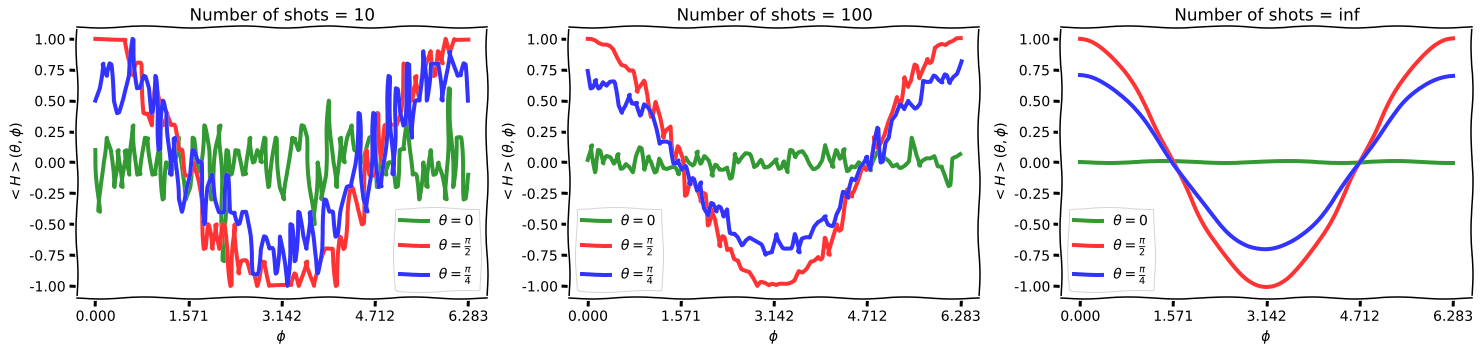

In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm


def mean_value_x(th,phi,shots=10):
    #this function generates a circuit determined by the values of (phi, th) and estimate
    #the mean value of \Sigma_x by measuring in the z-basis a "shots" number of repetitions.
    circuit = [qc.ry(th), qc.rz(phi)]
    unitary = qc.unitary(circuit)
    output_state = qc.output_state(unitary)
    return qc.observable_mean(output_state, operator="x", shots=shots)

def get_phis(th,shots=np.inf):
    #this is just a sweep over different values of the z-axis-rotation.
    mphi = []
    phis = np.linspace(0,2*np.pi,100)
    for ph in phis:
        mphi.append(mean_value_x(th, ph,shots=shots))
    return mphi
    
phis = np.linspace(0,2*np.pi,100)
#plotting program
plt.xkcd()
plt.figure(figsize=(25,5))
ax1,ax2,ax3 = [plt.subplot2grid((1,3),(0,k)) for k in range(3)]
for ax, shot in zip([ax1,ax2,ax3],[10,100,np.inf]):
    ax.set_title("Number of shots = {}".format(shot))
    ax.plot(phis,get_phis(0,shots=shot),color="green", linewidth=4, alpha=.8,label=r'$\theta = 0$')
    ax.plot(phis,get_phis(np.pi/2,shots=shot),color="red", linewidth=4, alpha=.8,label=r'$\theta = \frac{\pi}{2}$')
    ax.plot(phis,get_phis(np.pi/4,shots=shot),color="blue", linewidth=4, alpha=.8,label=r'$\theta = \frac{\pi}{4}$')

    ax.set_xticks(np.arange(0,2*np.pi+np.pi/2,np.pi/2))
    ax.legend()
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$<H>(\theta, \phi)$')

Note: there's a lot of things to talk from this simple example. For instance, one would think that a way to find the minimum value of the energy is to randomly sweep over $(\theta, \phi)$ and explore further the region that seems to contain the minima. This sounds good, but how would you sample those parameters? How would you sample uniformly at random those parameters? Actually, even doing this is a subtle thing to do, since the notion of the <b>Haar measure</b> of an unitary group needs to be introduced; to learn more about that, we recommend <a href=https://pennylane.ai/qml/demos/tutorial_haar_measure.html >this reading</a>.

### Let's compare with the true value.

It is easy to show that for the hamiltonian we are considering ($H=X$), it holds 
\begin{eqnarray}
\langle\psi |H| \psi \rangle &=& \sin \theta \cos \phi \\
|\psi \rangle &=& \cos{\frac{\theta}{2}}|0 \rangle + \sin{\frac{\theta}{2} } e^{ i \phi}|1 \rangle, \\
\end{eqnarray}
and hence 
\begin{eqnarray}
\frac{\partial \langle\psi |H| \psi \rangle}{\partial \theta} &=& - \sin \theta \sin \phi \\
\frac{\partial \langle\psi |H| \psi \rangle}{\partial \phi} &=&  \cos \theta \cos \phi \\
\end{eqnarray}

We can ues this information to check that things are OK with parameter-shift rule

Text(0.5, 0, '$<H>$')

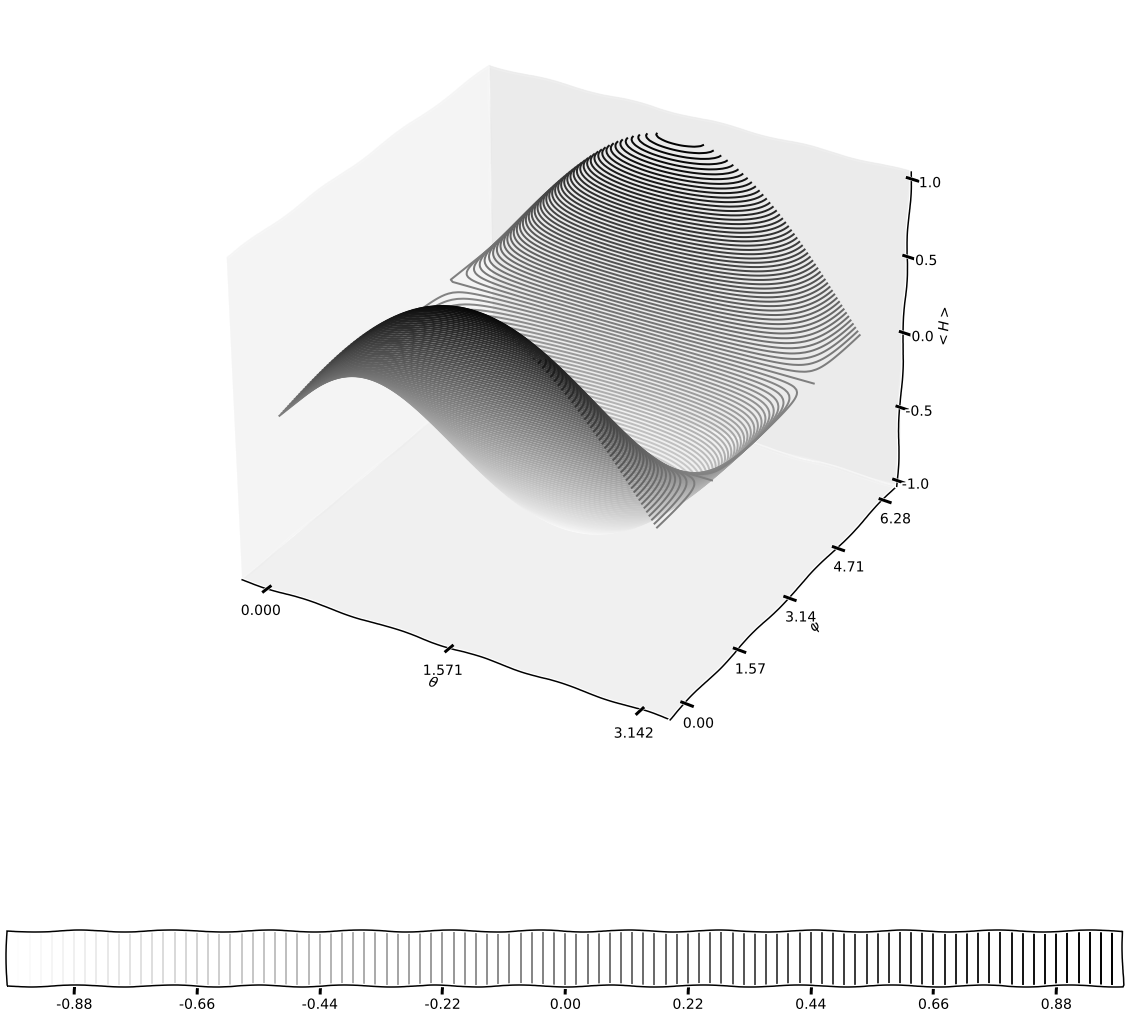

In [4]:
def energy_landscape(th, phi):
    return np.sin(th)*np.cos(phi)

thetas = np.linspace(0, np.pi, 100)
phis = np.linspace(0, 2*np.pi, 100)

Thetas, Phis = np.meshgrid(thetas, phis)
Energies = energy_landscape(Thetas, Phis)

fig = plt.figure(figsize=(20,20))

ax = plt.axes(projection='3d')
im=ax.contour3D(Thetas, Phis, Energies, 100, cmap="binary",vmin=-1,vmax=1)
colorbar =fig.colorbar(im,ax=ax, orientation="horizontal")#,aspect=20,shrink=0.8)

ax.set_xticks(np.arange(0,2*np.pi+np.pi/2,np.pi/2))
ax.set_yticks(np.arange(0,2*np.pi+2*np.pi+np.pi/2,np.pi/2))
ax.set_zticks(np.arange(-1.,1.5,.5))

ax.set_zlim([-1,1])
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
ax.set_zlabel(r'$<H>$')


### Classical optimization

<p>We pose ourselves in a situation at which we ignore the energy landscape, and we need to perform measurements in order to <b>estimate </b> where the optimal parameters are. There are many ways to do this, for example using a black-box optimizer that samples different regions of the parameter space according to some pre-defined strategy. Alternatively, we could imagine a situation at which one <i>measures</i> the gradient of the energy w.r.t. to some parameter; if this was the case, we could use gradient-based methods to aid the help over the parameter space. </p>

<p>It turns out that measuring derivatives of parametrized quantum circuits is quite easy: one should simply evaluate the function we want to derive at two different points, and compute the difference. This is known as the parameter-shift rule, and we should note that is <b>exact</b>, not an approximation as we would do with finite differences (assuming we perform infinite number of measurements). You can <a href=https://pennylane.ai/qml/glossary/parameter_shift.html>learn more about parameter-shift rules here</a>; in the following we will just state the result.</p>

<p> Suppose we want to compute the derivative of $\langle\psi(\vec{\theta}) |H| \psi(\vec{\theta}) \rangle$, where $|\psi(\vec{\theta}) \rangle = U(\vec{\theta}) |0\rangle$. Here, $ U(\vec{\theta})$ represents a parametrized quantum circuit which in our case reads $R_y(\theta) R_z(\phi) = e^{- i \frac{\theta \sigma_y}{2}}  e^{- i \frac{\phi \sigma_z}{2}}$. The parameters of our circuits are of course $\vec{\theta} = (\theta, \phi)$. Then, it holds that

\begin{eqnarray}
\frac{\partial \langle\psi(\theta, \phi) |H| \psi(\theta, \phi) \rangle}{\partial \theta} &=&  \langle\psi(\theta + \frac{\pi}{2}, \phi) |H| \psi(\theta+ \frac{\pi}{2}, \phi) \rangle  -  \langle\psi(\theta - \frac{\pi}{2}, \phi) |H| \psi(\theta- \frac{\pi}{2}, \phi) \rangle \\
\frac{\partial \langle\psi(\theta, \phi) |H| \psi(\theta, \phi) \rangle}{\partial \phi} &=&  \langle\psi(\theta , \phi + \frac{\pi}{2}) |H| \psi(\theta, \phi+ \frac{\pi}{2}) \rangle  -  \langle\psi(\theta , \phi- \frac{\pi}{2}) |H| \psi(\theta, \phi- \frac{\pi}{2}) \rangle \\
\end{eqnarray}
</p>

<p>This means that we do only need to measure the expected value of the hamiltonian on two different circuits (shifted by $\pm \frac{\pi}{2}$ so to measure the gradient. We can see this as a recipe to compute gradients of quantum circuits. Moreover, we can think the quantum circuit we are considering as outputing a function, and what we are currently considering is how to take its derivatives. In the machine learning world, automatizing derivation is something very important, and much work has been put forward in that direction; as the name suggest, there's a whole technique called "automatic differentiation", which heavily relies on differential geometry, which allows one to derivate a function defined in a script with respect to its parameters. Much of the importance of machine learning libraries is due to its <a href="https://en.wikipedia.org/wiki/Automatic_differentiation" >automatic differentiation </a> methods; check this <a href="https://youtu.be/wG_nF1awSSY?t=272" > video </a> to get an idea of how AD works. In the second part of the tutorial we will make use of libraries including quantum automatic differentiation methods (which is nothing more than a fancy name for doing automatic differentiation using gradient-shift rules above explained).
    
    
In the following, we will numerically check that this holds for our circuits, and then use this to optimize the parameters</p>






In [5]:
def get_gradients(th,phi,shots=10):
    
    gtheta = 0
    for shift, constant in zip([np.pi/2, -np.pi/2], [1,-1]):
        circuit = [qc.ry(th+shift), qc.rz(phi)]
        unitary = qc.unitary(circuit)
        output_state = qc.output_state(unitary)
        gtheta += constant*qc.observable_mean(output_state, operator="x", shots=shots)
    
    gphi = 0
    for shift, constant in zip([np.pi/2, -np.pi/2], [1,-1]):
        circuit = [qc.ry(th), qc.rz(phi+shift)]
        unitary = qc.unitary(circuit)
        output_state = qc.output_state(unitary)
        gphi += constant*qc.observable_mean(output_state, operator="x", shots=shots)
    return gtheta/2, gphi/2

### Gradients landscape

Let's look now at the gradient's landscape: we will check that things are OK with the parameter-shift rule (how? well... by measuring the system, as we would do if we were at the lab!)

In [6]:
def grad_th(th, phi):
    ## this function gives the energy gradient wrt theta (analytical)
    return np.cos(th)*np.cos(phi)

### now we sweep over some values of theta, phi to measure gradients using the (simulated) quantum computer
### for each configuration we measure using 25 number of measurements (note that actually each gradient requires twice this value)
### since we are using the parameter-shift rule

ResTh, ResPh = 100, 100
thetas_qc = np.linspace(0, np.pi, ResTh)
phis_qc = np.linspace(0, 2*np.pi, ResPh)

th1d,ph1d,grad_th1d = [],[],[]

for indth, th in enumerate(tqdm(thetas_qc)):
    for indph, ph in enumerate(phis_qc):
        grads=get_gradients(th,ph,shots=25)

        th1d.append(th)
        ph1d.append(ph)
        grad_th1d.append(grads[0])


100%|██████████| 100/100 [00:03<00:00, 32.05it/s]


/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 0, '$<H>$')

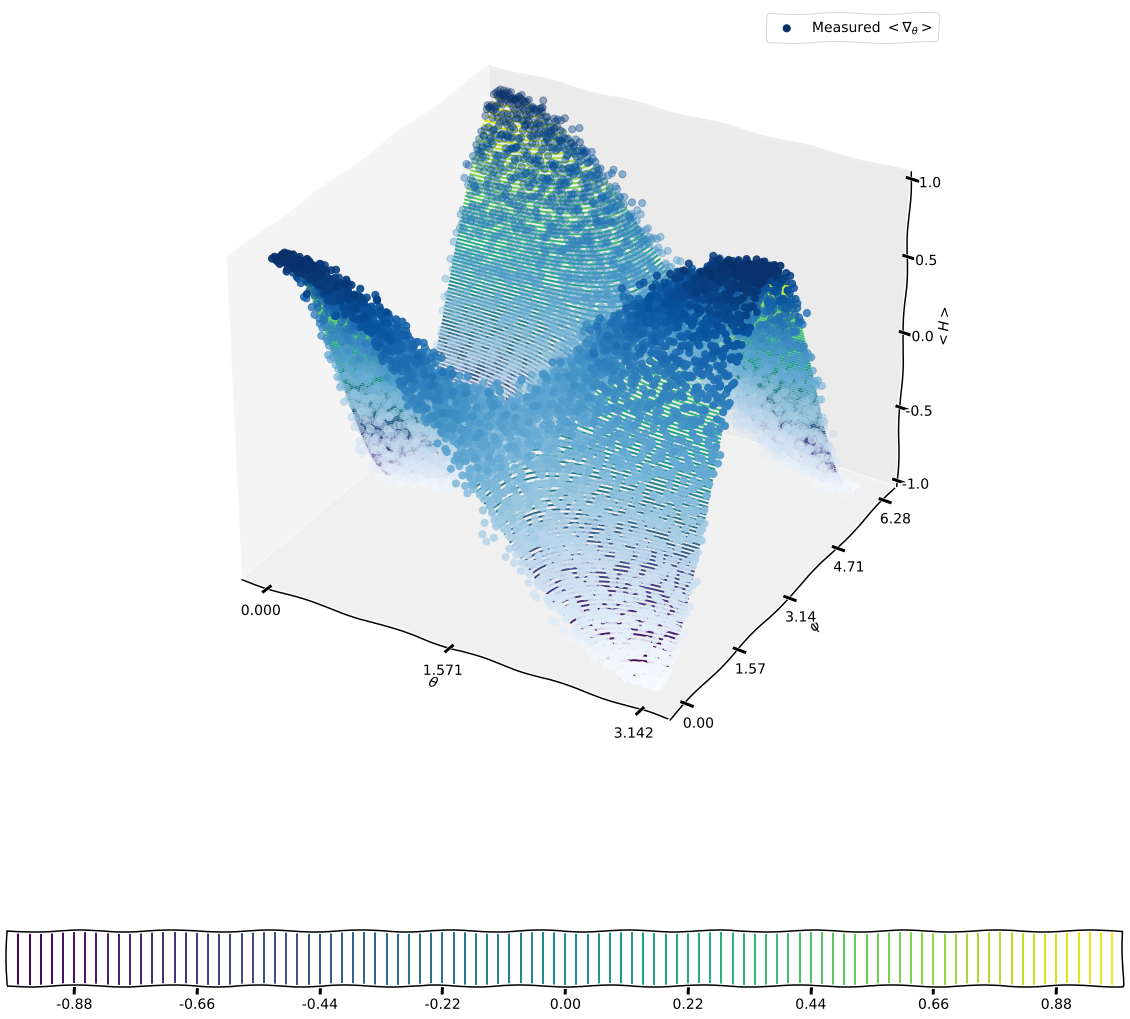

In [7]:
### Let's plot everything together!    
        
Thetas, Phis = np.meshgrid(thetas, phis)
Grad_th = grad_th(Thetas, Phis)

fig = plt.figure(figsize=(20,20))

ax = plt.axes(projection='3d')
ax.scatter3D(th1d,ph1d, grad_th1d,c=grad_th1d,s=50,cmap='Blues', label="Measured "+r'$< \nabla _\theta >$')
im=ax.contour3D(Thetas, Phis, Grad_th, 100,vmin=-1,vmax=1, label="True")# "+r'$< \nabla _\theta >$'
colorbar =fig.colorbar(im,ax=ax, orientation="horizontal")

ax.set_xticks(np.arange(0,2*np.pi+np.pi/2,np.pi/2))
ax.set_yticks(np.arange(0,2*np.pi+2*np.pi+np.pi/2,np.pi/2))
ax.set_zticks(np.arange(-1.,1.5,.5))

ax.legend()
ax.set_zlim([-1,1])
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
ax.set_zlabel(r'$<H>$')

## Gradient-descent

In real-world problems, we don't have the luxury of plotting the energy landscape for different parameters, nor it is straigthforward to know which is the minimizing direction. To this end, we make use of classical optimization routines (which are the very same than we use in machine learning, e.g. SGD, Adam, etc.)


Here, we will use probably the simplest gradient-based optimization routine, which is Gradient-descent. Given a function $f(\vec{\theta})$, such that $f(\vec{\theta}^*) = \underset{\vec{\theta}}{\text{min}} f(\vec{\theta})$, we simply update the parameters in the negative direction of the gradient, aiming to guide them towards the optimal ones, $\vec{\theta}^*$:

\begin{equation}
\vec{\theta}_{new}  = \vec{\theta}_{old} - \alpha \nabla f |_{\vec{\theta} = \vec{\theta}_{old}}
\end{equation}

where $\alpha$ is the <i> learning rate </i>, which regulates how strong the update is. In the code below, we implement gradient descent to updates the quantum circuit parameters, ($\theta$, $\phi$). Feel free to play around with initialization of parameters and learning rate!

In [8]:
def gradient_descent_step(params, grads, lr=0.1):
    new_params = params - lr*grads
    return new_params

100%|██████████| 1000/1000 [00:00<00:00, 2660.99it/s]


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


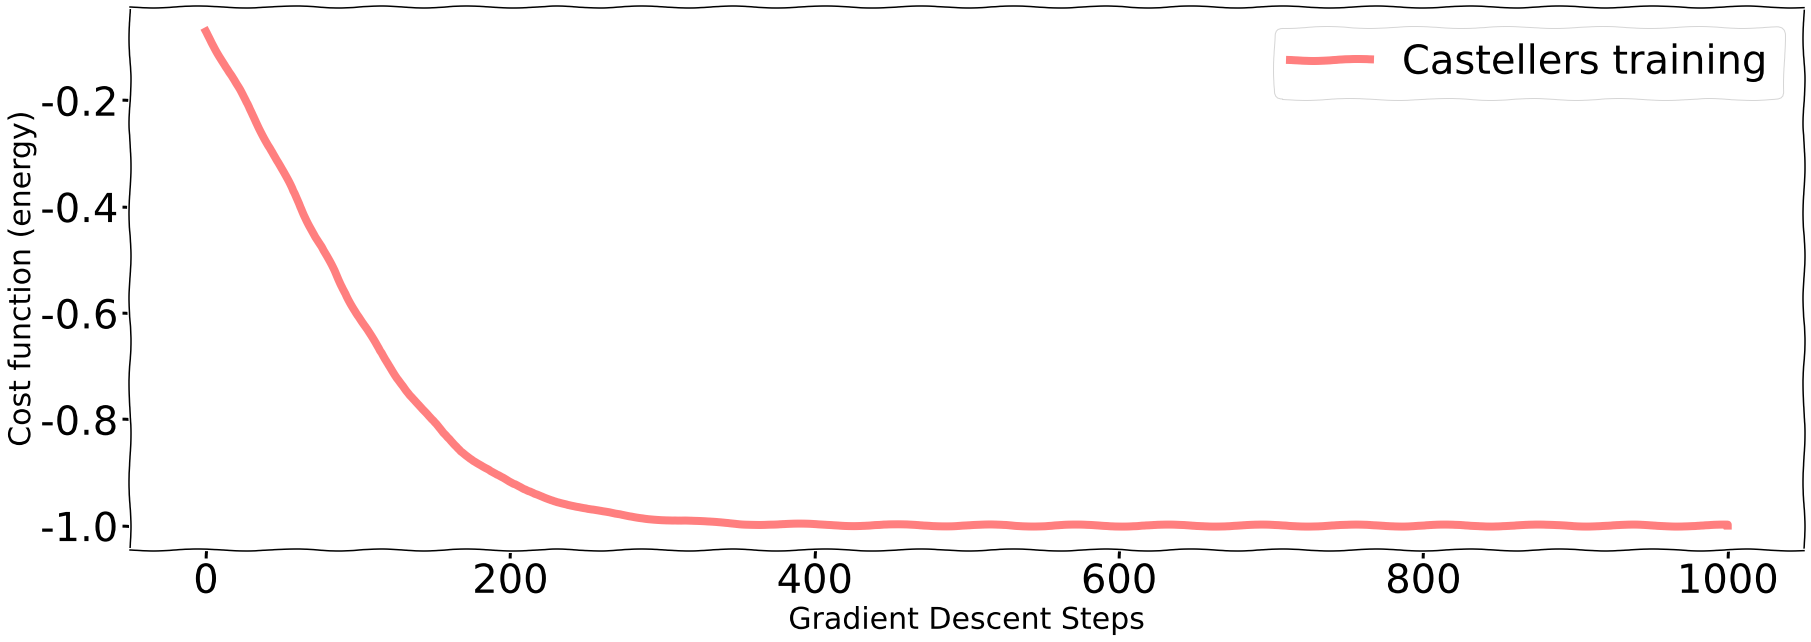

In [9]:
th, phi = np.pi/4, np.pi/2 + 0.1
params = np.array([th, phi])
trajectory_params = []
trajectory_energy=[]

energy = mean_value_x(*params,shots=np.inf)
trajectory_energy.append(energy)
trajectory_params.append([params])


for iteration in tqdm(range(1000)):
    grads = get_gradients(*params, shots=100)
    params = gradient_descent_step(params,np.array(grads), lr=0.01)
    
    energy = mean_value_x(*params,shots=np.inf)
    trajectory_params.append([params])
    trajectory_energy.append(energy)
    


plt.figure(figsize=(30,10))
plt.plot(trajectory_energy, linewidth=8, color="red", alpha=0.5, label="Castellers training")
plt.xlabel("Gradient Descent Steps",size=30)
plt.xticks(size=40)
plt.yticks(size=40)
plt.ylabel("Cost function (energy)",size=30)
plt.legend(prop={"size":40})

We can also plot the trajectory in the space $(\theta, \phi)$. Note that our optimizer does not take into account the restrictions of the parameters, so we chose some initial values s.t. we converge to a point inside that region. Otherwise we would obtain a point outisde, that we can map inside the are $\theta, \phi \in [0,\pi] \times [0, 2 \pi)$

Text(0.5, 0, '$<H>$')

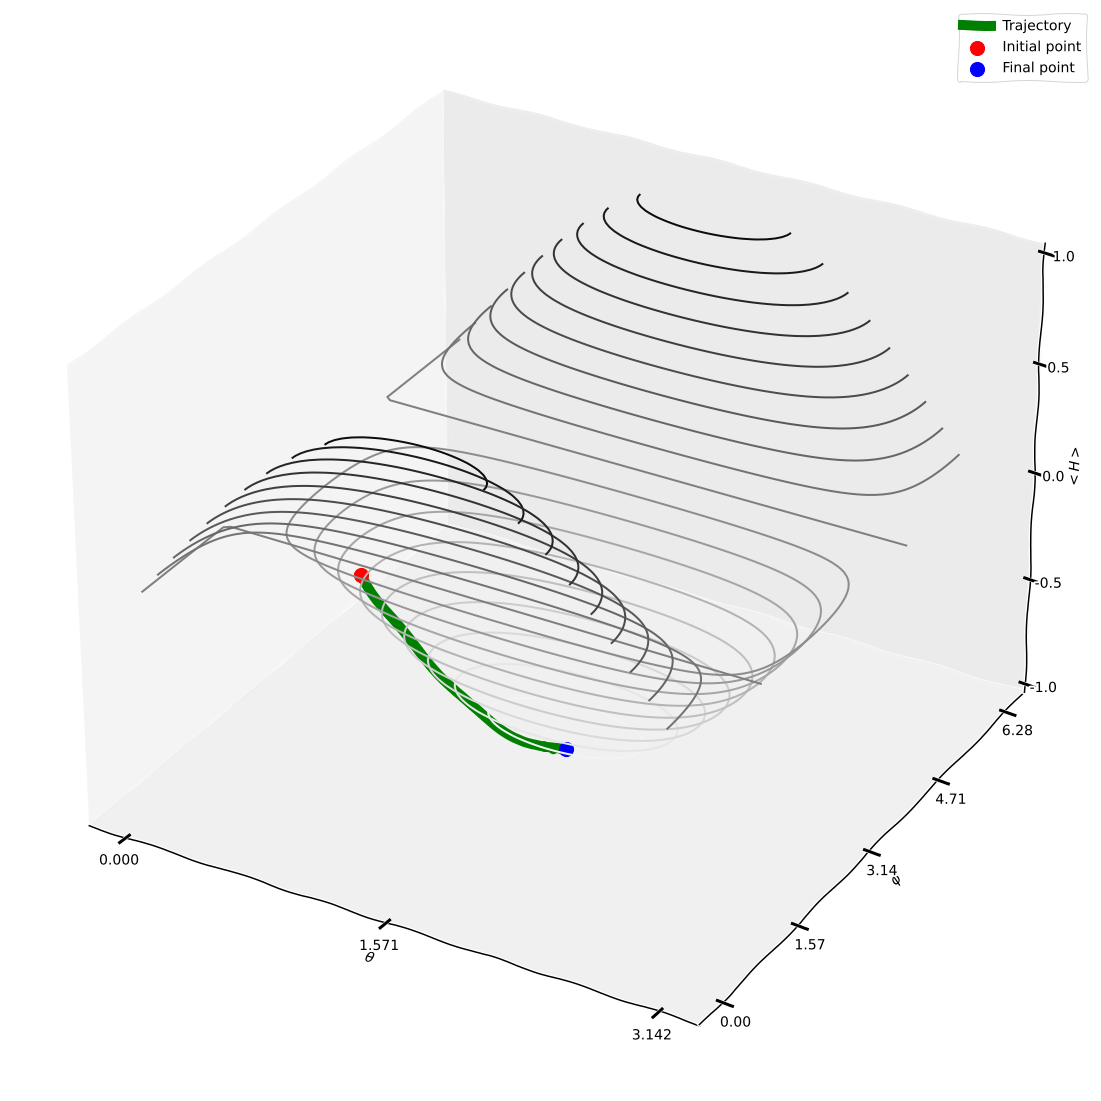

In [10]:
traj_params = np.squeeze(np.array(trajectory_params))

thetas = np.linspace(0, np.pi, 100)
phis = np.linspace(0, 2*np.pi, 100)

Thetas, Phis = np.meshgrid(thetas, phis)
Energies = energy_landscape(Thetas, Phis)

fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')

ax.plot3D(traj_params[:,0],traj_params[:,1], trajectory_energy, alpha=1, linewidth=10, color="green", label="Trajectory")

im=ax.contour3D(Thetas, Phis, Energies, 20, cmap="binary",vmin=-1,vmax=1)

ax.scatter3D(traj_params[:,0][0],traj_params[:,1][0], trajectory_energy[0], s=200, color="red", label="Initial point")
ax.scatter3D(traj_params[:,0][-1],traj_params[:,1][-1], trajectory_energy[-1], s=200, color="blue", label="Final point")

#colorbar =fig.colorbar(im,ax=ax, orientation="horizontal")#,aspect=20,shrink=0.8)
ax.set_xticks(np.arange(0,2*np.pi+np.pi/2,np.pi/2))
ax.set_yticks(np.arange(0,2*np.pi+2*np.pi+np.pi/2,np.pi/2))
ax.set_zticks(np.arange(-1.,1.5,.5))

ax.legend()
ax.set_zlim([-1,1])
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
ax.set_zlabel(r'$<H>$')

# PART 2: PennyLane

By studying the 1-qubit system, we have been able to introduce some basic ideas. For instance, we defined what a parametrized quantum circuit is, how to measure the system in a given basis, and hence how to estimate the expected value of a given Hamiltonian. Note that this is completely general, since the Pauli operators constitute an operator basis in the space of Hermitian operators, and hence any Hamiltonian can be written as a weighted sum of Pauli observables (and the identity). In turn, this generalizes if more than one qubit is under consideration: the basis is now formed by the tensor product of Pauli observables, and any expected value of a certain Hamiltonian can be efficiently estimated by measuring each term of its decomposition in a Pauli basis. This feature (and many more!) are included in <i> quantum libraries </i> such as <a href="https://pennylane.readthedocs.io/en/stable/"> Penny Lane </a> , <a href= "https://quantumai.google/cirq">Cirq</a> (Google), <a href="https://qiskit.org/">Qiskit</a> (IBM) and <a href="https://qosf.org/project_list/" >so many more</a>.

In this second part of the tutorial, we will dive into PennyLane, which is famous for being a <i> platform agnostic </i> quantum library. Most of quantum software libraries are developed by companies, who are dedicated (among other things) to develop a quantum processor; this is also the case of PennyLane, whose developing team is mostly composed by people from <a href="https://www.xanadu.ai/">Xanadu</a>. However, in contrastst to other libraries, PennyLane shines because it facilitates running all the stuff coded in its language to other quantum computing softwares (and hardwares). For instance, one could potentially exploit some part of Google's hardware, some other part of IBM's hardware, but code everything up using PennyLane. Moreover, it does not only talk well with quantum software libraries, but also with machine learning ones (such as Theano, TensorFlow, or Torch), leaving things quite comfortable so to investigate the interplay between quantum information and machine learning. For this reason, our first steps here will be taken using PennyLane shoes.

<b> <u>Note:</u> </b> Despite we will go very quickly through the definitions of quantum circuits, qubits and gradients using PennyLane, it is highly recommendable (and enjoyable) to surf into the tutorials. In fact, they have been written by very prominent researchers in the field of quantum information theory.



### Revisting our caballito de batalla :) 

Let's first re-construct the objective function and gradients. We will import pennylane library as qml (that stands for quantum machine learning).

To define a quantum circuit in PennyLane, we first need to define a device (that is, which is the device at which we will run our quantum program, if it is a simulator or a real quantum device, if it is a qubit, etc.). This is done via the $\texttt{qml.device()}$ module. We will use "default.qubit", (e.g. work with qubits), and set the number of wires (that is, in this case, the number of qubits) to 1, so we reconstruct the results obtained at previous section. Moreover, we will play with the "shots" variable, to make an identical plot of the one previosly made.

Once defined the quantum device, we should define our circuit. This consists on defining a function, which we call below OneQubitHamiltonian_X; the inputs of the function are the parameters of the rotations, whereas the output is what what we measure (in this case, the expected value of the hamiltonian $\sigma_x = X$). Note that pennyLane allows for a lot of flexibility here, and many things can happen inside this function, i.e. doing some Machine Learning processing stuff. <b> Importantly </b> we need to use a <a href="https://www.datacamp.com/community/tutorials/decorators-python"> decorador </a>, in this case the @qml.qnode(device), where device is a qml.device() object. Overall, this connects the circuit defined in the (decorated) function with its correspondent device in quite a straightforward way: just put the @decorator.

Below, we show the results of estimating the energy of the 1-qubit Hamiltonian we have previously considered. Note that, under the hood, PennyLane is using the very same tricks we have explained in the first part of tutorial (e.g. change of basis, sample on Z, estimate expected values)

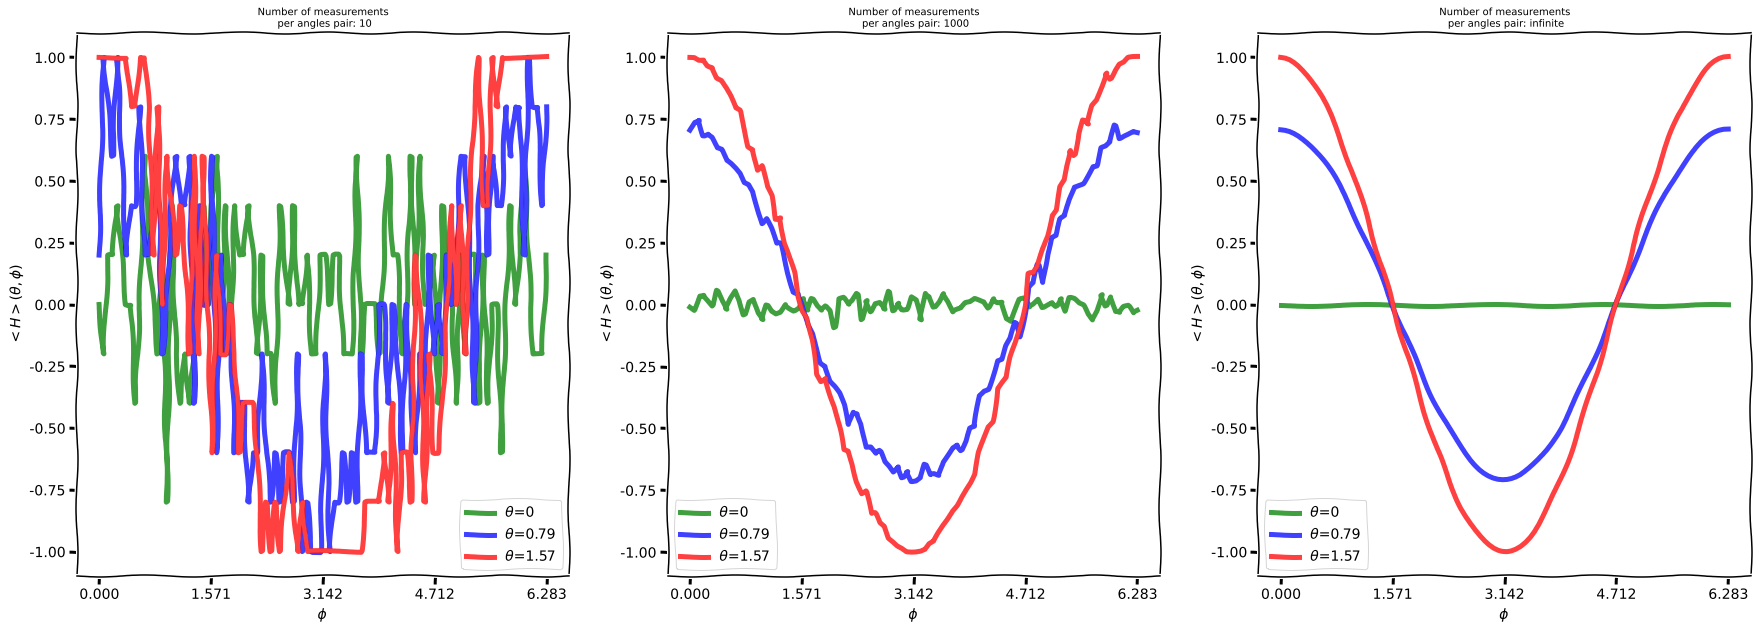

In [11]:
import pennylane as qml

phis = np.linspace(0,2*np.pi,100)
plt.figure(figsize=(30,10))
def fun(shots):
    if isinstance(shots,int):
        return shots
    else:
        return "infinite"
    
for k,shots in enumerate([10, 1000, None]):

    quantum_device = qml.device('default.qubit', wires=1, shots=shots)
    @qml.qnode(quantum_device)
    def OneQubitHamiltonian_X(theta, phi):
        qml.RY(theta, wires=0)
        qml.RZ(phi, wires=0)
        return qml.expval(qml.PauliX(0))


    ax=plt.subplot2grid((1,3),(0,k))
    ax.set_title("Number of measurements\n per angles pair: {}".format(fun(shots)), size=10)
    for theta, color in zip([0, np.pi/4, np.pi/2], ["green", "blue", "red"]):
        ax.plot(phis,[OneQubitHamiltonian_X(theta,phi) for phi in phis], color=color, linewidth=5, alpha=.75, label=r'$\theta$'+"={}".format(np.round(theta,2)))
    ax.set_xticks(np.arange(0,2*np.pi+np.pi/2,np.pi/2))
    ax.legend()
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$<H>(\theta, \phi)$')

Let's see how to take circuit derivatives now!

In [12]:

quantum_device = qml.device('default.qubit', wires=1, shots=1000)
@qml.qnode(quantum_device, diff_method="parameter-shift")
def OneQubitHamiltonian_X(theta, phi):
    qml.RY(theta, wires=0)
    qml.RZ(phi, wires=0)
    return qml.expval(qml.PauliX(0))

#Here, dcircuit(theta, phi) will output [d <H> / d theta,  d <H> / d phi ] evaluated at the input points
dcircuit = qml.grad(OneQubitHamiltonian_X)

In [13]:
pennyGrads=[]
th1d_penny=[]
ph1d_penny=[]
thetas = np.linspace(0,np.pi,50)
phis = np.linspace(0,2*np.pi,50)
for th in tqdm(thetas):
    for phi in phis:
        th1d_penny.append(th)
        ph1d_penny.append(phi)
        pennyGrads.append(dcircuit(th,phi)[0])

100%|██████████| 50/50 [00:08<00:00,  5.82it/s]


/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 0, '$<H>$')

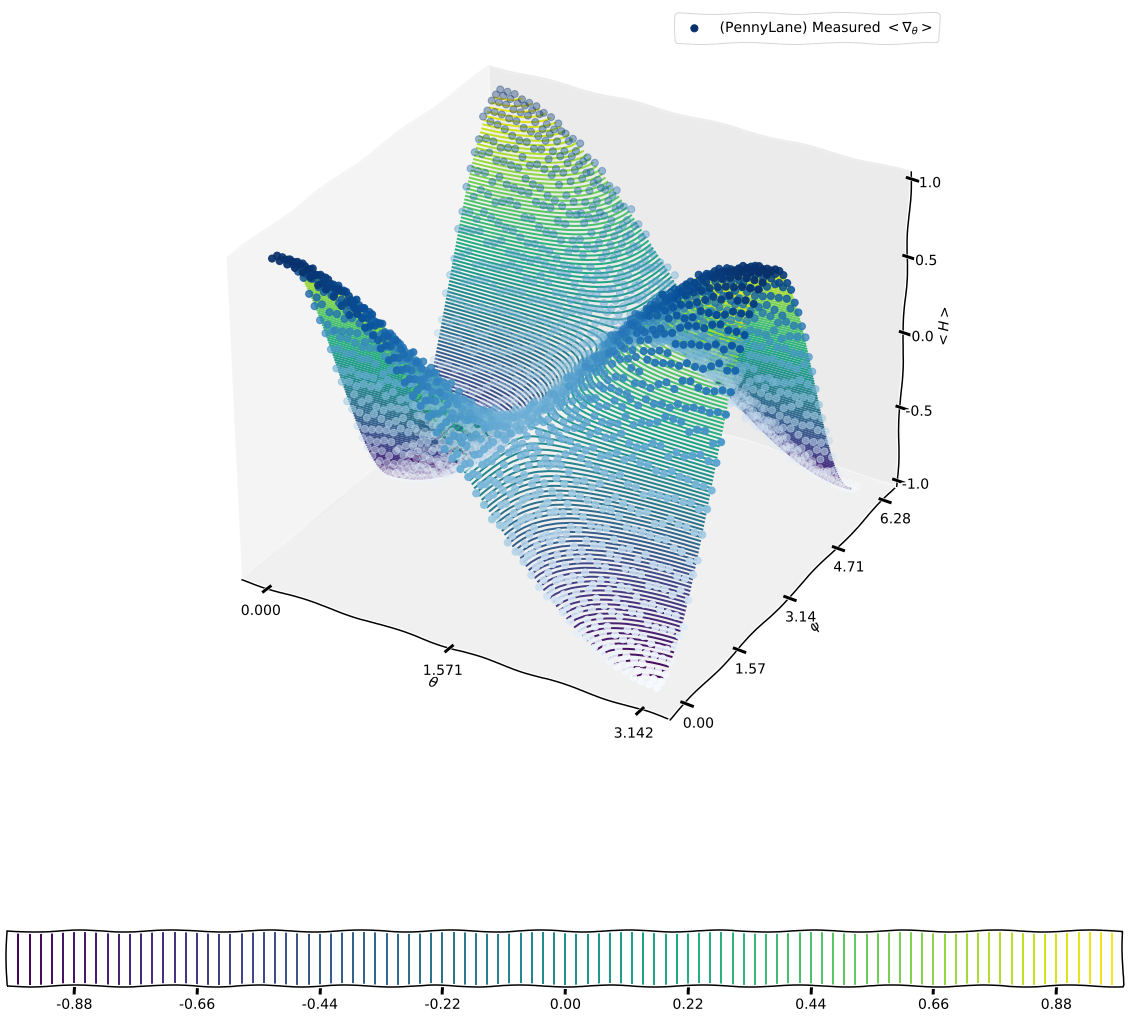

In [14]:
### Let's plot everything together!
        
Thetas, Phis = np.meshgrid(thetas, phis)
Grad_th = grad_th(Thetas, Phis)

fig = plt.figure(figsize=(20,20))

ax = plt.axes(projection='3d')
ax.scatter3D(th1d_penny,ph1d_penny, pennyGrads,c=pennyGrads, s=50,cmap='Blues', label="(PennyLane) Measured "+r'$< \nabla _\theta >$')
im=ax.contour3D(Thetas, Phis, Grad_th, 100,vmin=-1,vmax=1, label="Exact (homework :) )")# "+r'$< \nabla _\theta >$'
colorbar =fig.colorbar(im,ax=ax, orientation="horizontal")

ax.set_xticks(np.arange(0,2*np.pi+np.pi/2,np.pi/2))
ax.set_yticks(np.arange(0,2*np.pi+2*np.pi+np.pi/2,np.pi/2))
ax.set_zticks(np.arange(-1.,1.5,.5))

ax.legend()
ax.set_zlim([-1,1])
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
ax.set_zlabel(r'$<H>$')

So, we have shown how to define a quantum circuit in PennyLane, and how to compute its derivatives. Now let's review how to do gradient descent, so we have all elements from the previous example coded up in this <a href="https://www.youtube.com/watch?v=S-rB0pHI9fU">Beatle-like</a> language.



In [15]:
def cost(x):
    return OneQubitHamiltonian_X(*x)

cost_evolution = []
opt = qml.GradientDescentOptimizer(stepsize=0.1)

steps = 100
params = np.array([np.pi/4, np.pi/2 + 0.1])

for i in tqdm(range(steps)):
    # update the circuit parameters
    params = opt.step(cost, params)
    cost_evolution.append(cost(params))

100%|██████████| 100/100 [00:00<00:00, 218.25it/s]


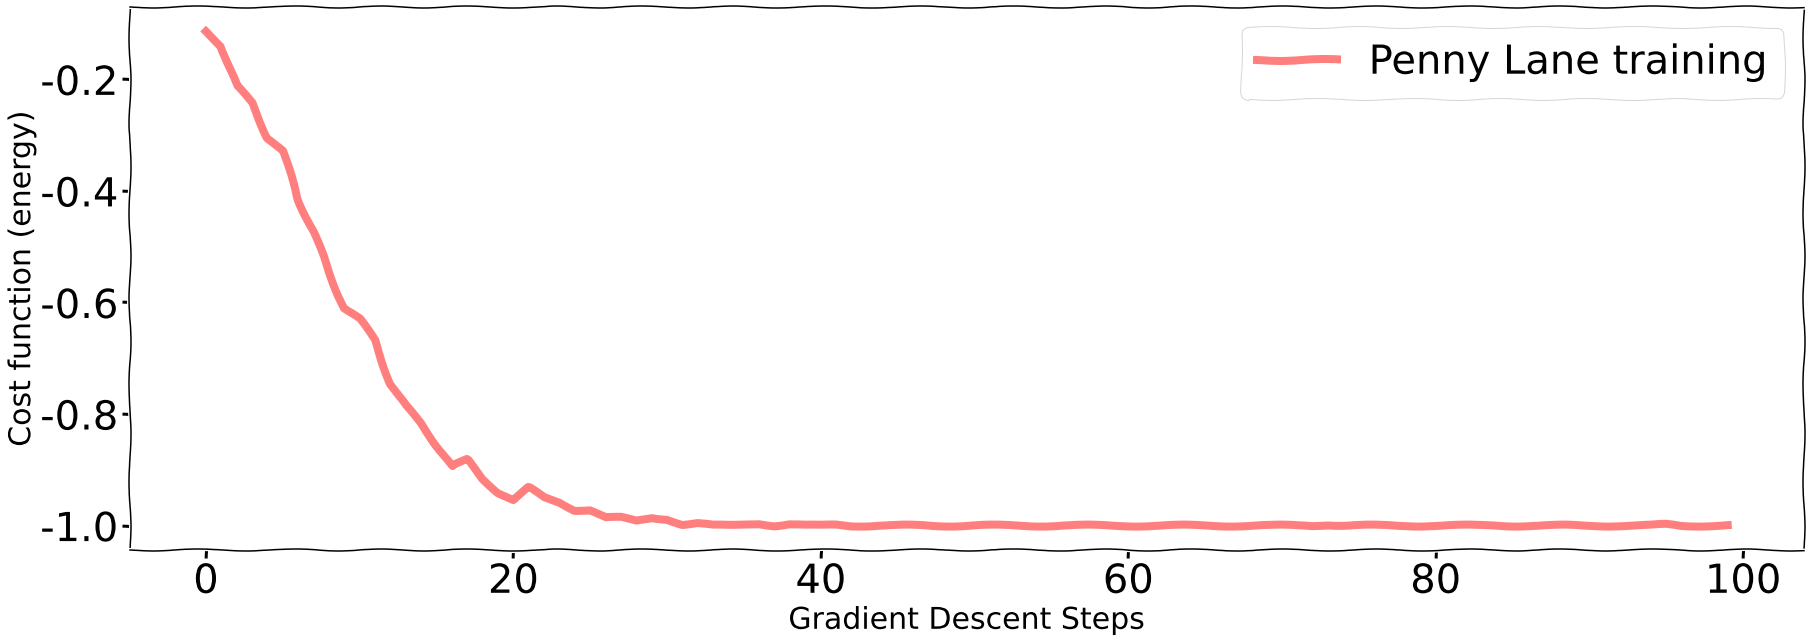

In [16]:
plt.figure(figsize=(30,10))
plt.plot(cost_evolution, linewidth=8, color="red", alpha=0.5, label="Penny Lane training")
plt.xlabel("Gradient Descent Steps",size=30)
plt.xticks(size=40)
plt.yticks(size=40)
plt.ylabel("Cost function (energy)",size=30)
plt.legend(prop={"size":40})

Having understood how to do these standard operations using PennyLane, we can now move a step forward, an consider 2-qubit systems.

We will consider a hamiltonian of the form

$H =  \sigma^{(1)}_x\otimes \sigma^{(2)}_x +  \sigma^{(2)}_z \otimes \sigma_z^{(2)} =  X_1 X_2 + Z_1 Z_2$

Again, finding the spectrum of this operator and the lowest eigenstate can easily be done here. For instance, we can quickly see that the lowest-energy eigenstate correspond to the singlet state, i.e. $|\psi\rangle = \frac{1}{\sqrt{2}}( |01\rangle-|10\rangle)$, with energy $E_0 = -2$. Let's check that using numpy:

<b> <u>Note </u></b>: this routine returns 2 items. The first one is a list of eigenvalues sorted in crescendo
the second one is the transformation matrix that takes you from computational basis to
that one at which Hamiltonian is diagonal, and whose columns are the eigenstates of Hamiltonian, sorted in crescendo
with respect to the eigenvlaues. Hence, first column will be the eigenstate with lowest energy, and last column
that eigenstate with the highest.

In [17]:
#We borrow pauli matrices from penny lane
X=qml.PauliX.matrix 
Z=qml.PauliZ.matrix
Hamiltonian = np.kron(*[X,X]) +np.kron(*[Z,Z])

np.linalg.eigh(Hamiltonian) 

(array([-2.,  0.,  0.,  2.]),
 array([[ 0.        , -0.70710678,  0.        , -0.70710678],
        [-0.70710678,  0.        , -0.70710678,  0.        ],
        [ 0.70710678,  0.        , -0.70710678,  0.        ],
        [ 0.        ,  0.70710678,  0.        , -0.70710678]]))

By noticing that $\frac{1}{\sqrt{2}} \sim 0.7071678$, we corroborate that the singlet is the lowest state. Just in case:

In [18]:
singlet = np.array([0,1,-1,0])/np.sqrt(2)
def expected_value(observable, state):
    return np.dot(state, np.dot(observable, state))
expected_value(Hamiltonian, singlet)

-1.9999999999999996

Now we will take profit of PennyLane library to optimize parametrized circuits aiming to attain the minimum-energy state for the hamiltonian $H = XX + ZZ$.

To this end, we will consider two different circuits. The first circuit will be a "separable" one, that means that systems don't get correlated. Hence, we will apply the most general 1-qubit unitary transformation (that is, an Euler rotation) on each qubit and that's it. You may wonder that I refer to Euler rotation, but there's only two rotations instead of three... could you tell where the third rotation has been absorbed?

On the other hand, we will consider a circuit that correlates the two systems, via the so-called <a href="https://en.wikipedia.org/wiki/Controlled_NOT_gate"> CNOT gate </a>. This gate takes two inputs, a control qubit and a target qubit. As the name suggest, this is a Controlled negation (the classical counterpart is called XOR gate), and negates the logical value of the target qubit, depending on the value of the control one. The following table describes the action of the CNOT gate in the computational basis. Note that any state living on the Hilbert space of two-qubits can be written in terms of this basis, and (as always) we can inspect the action of the CNOT gate on any state by knowing how it transforms the computational basis elements.

<img src="figures/cnot.png">

Hence, we will consider the second circuit as a general two qubit rotation acting on each qubits at the beggining of the circuit, then a CNOT gate, and two local rotations around the y-axis. A drawing of each circuit can be found below.

Separable circuit:
<img src="figures/2qubit_separable.png">


Entangling circuit:
<img src="figures/2qubit_entangled.png">


Below we define those circuits in PennyLane. There's a subtle difference with respect to the one-qubit example we considered above. The main difference is that since the new hamiltonian involve non-commutable terms, we cannot use a single circuit to estimate both terms; for instance we cannot simmultaneously measure $X_1$ and $Z_1$. For this reason, we need to construct more than one circuit, and estimate each term separately, and then re-construct the expected energy by averaging up with the corresponding weigths of each Pauli observable. Fortunately, all of this is handled by PennyLane library, by using a module called VQE (which stands for Variational Quantum Eigensolver). As an excercise, you could try to re-do the example we will show below, using the scheme presented above (that is, without the help of the VQE module).

In order to use this PennyLane-VQE module, circuits need to be defined sligthly different: all gates are passed in the desired order, and no decorator needs to be used; all wrapping is done via the module. To learn a bit more, feel free to check out <a href="https://pennylane.readthedocs.io/en/stable/code/api/pennylane.ExpvalCost.html#pennylane.ExpvalCost">the documentation</a>, or the <a href="https://pennylane.readthedocs.io/en/stable/_modules/pennylane/vqe/vqe.html">source-code </a>.

In [19]:
def SeparableCircuit(params,**kwargs):
    qml.RY(params[0], wires=0)
    qml.RZ(params[1], wires=0)
    qml.RY(params[2], wires=1)
    qml.RZ(params[3], wires=1)
    
def EntangledCircuit(params,**kwargs):
    qml.RY(params[0], wires=0)
    qml.RZ(params[1], wires=0)
    qml.RY(params[2], wires=1)
    qml.RZ(params[3], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RY(params[4], wires=0)
    qml.RY(params[5], wires=1)    
    
    
#### Coefficients accompaying each term in the hamiltonian (in our case, it's 1 for each Pauli term)
coeffs = [1,1]

#### A list of Pauli Observables (i.e. tensor products of local Pauli observables) that consitute the Hamiltonian.

obs = [
    qml.PauliX(0)@qml.PauliX(1),
    qml.PauliZ(0)@qml.PauliZ(1)
]

#### This is where we call the module, to construct the hamiltonian.
H_vqe_module = qml.vqe.Hamiltonian(coeffs, obs)


# Now we call the PennyLane module that communicates each circuit with the corresponding quantum_device and 
# the hamiltonian we have just defined. Under the hood, this 
# module creates a copy of the required number of circuits (two in this case) to estimate each term,
# and finally returns the weighted sum of averages (coeff are the weights). This is essentially the reason why
# we need not to use the decorators nor return expected values.

quantum_device_separable = qml.device('default.qubit', wires=2, shots=1000)
quantum_device_entangled = qml.device('default.qubit', wires=2, shots=1000)


cost_separable = qml.ExpvalCost(SeparableCircuit, H_vqe_module , quantum_device_separable)
cost_entangled = qml.ExpvalCost(EntangledCircuit, H_vqe_module , quantum_device_entangled)


Having defined circuits, hamiltonians and expected values using VQE PennyLane API, we can now jump to trian both circuits. We will initialize them to identity in both cases, such that they both output the state $|0\rangle^{\otimes 2}$. In the following we will train the two circuits in the same training loop; note that for each circuit we define a different optimizer object (in the case of GradientDescentOptimizer this is not strictly necessary, but if one would like to consider some clever optimization routines such as Adapitve Moment estimation (Adam)I, where one keeps a learning rate for each parameter, it would then be mandatory to keep two separate optimizer objects.

In [20]:
costs_evolution = []
opt_separable = qml.GradientDescentOptimizer(stepsize=0.1)
opt_entangled = qml.GradientDescentOptimizer(stepsize=0.1)

steps = 100
params_entangled = np.array([0. for i in range(6)])
params_separable = np.array([0. for i in range(4)])

for i in tqdm(range(steps)):
    params_separable = opt_separable.step(cost_separable, params_separable)
    params_entangled = opt_entangled.step(cost_entangled, params_entangled)

    costs_evolution.append([cost_separable(params_separable), cost_entangled(params_entangled)])
costs_evolution=np.array(costs_evolution)

100%|██████████| 100/100 [00:04<00:00, 23.76it/s]


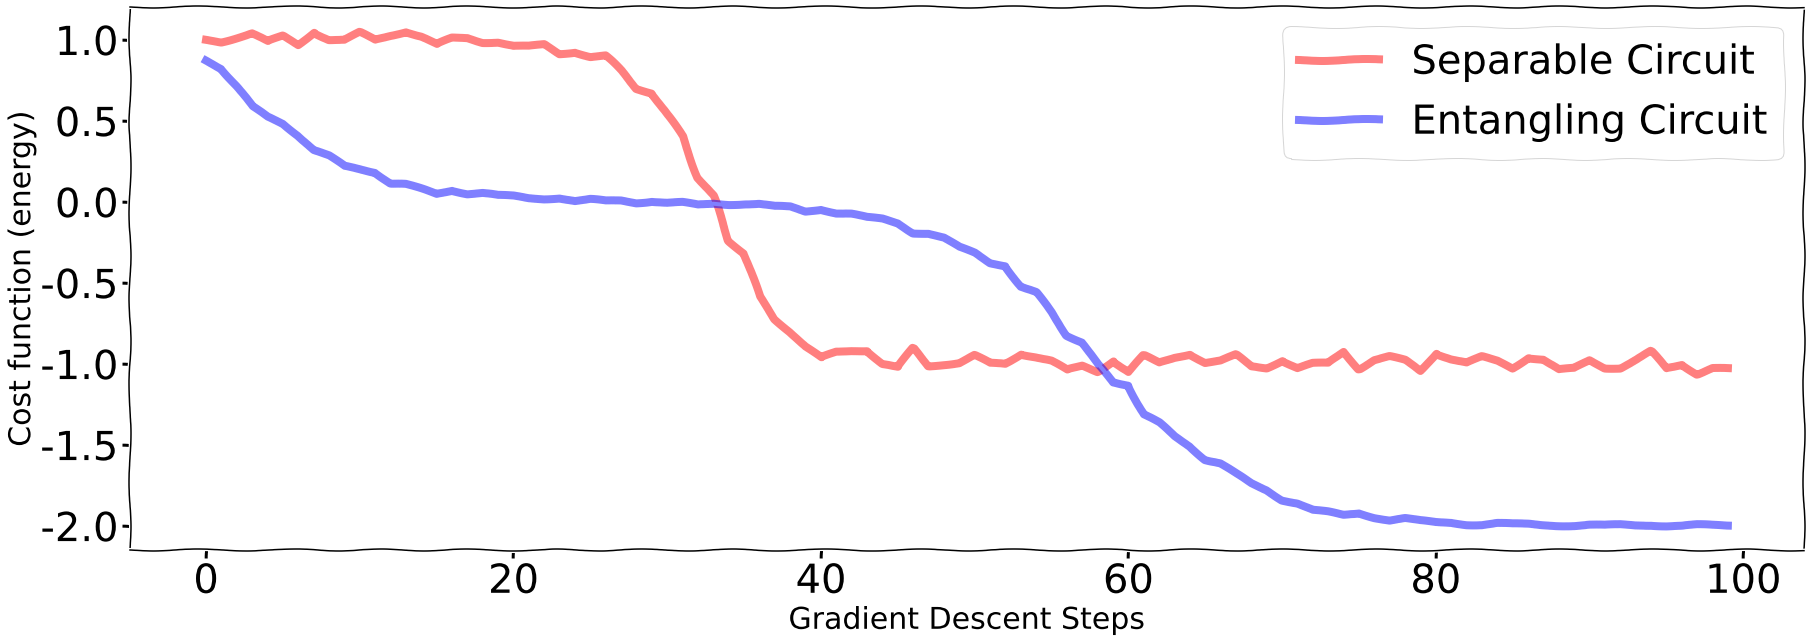

In [21]:
plt.figure(figsize=(30,10))
plt.plot(costs_evolution[:,0], linewidth=8, color="red", alpha=0.5, label="Separable Circuit")
plt.plot(costs_evolution[:,1], linewidth=8, color="blue", alpha=0.5, label="Entangling Circuit")

plt.xlabel("Gradient Descent Steps",size=30)
plt.xticks(size=40)
plt.yticks(size=40)
plt.ylabel("Cost function (energy)",size=30)
plt.legend(prop={"size":40})

We observe that the entangling circuit performs much better. As a matter of fact, there is no way to prepare an entangled state, such as the singlet $|\psi\rangle = \frac{1}{\sqrt{2}}( |01\rangle-|10\rangle)$, using only local rotations; the CNOT gate is a must here. In the following we will inspect which is the strategy at which our algorithm has converged to. Because it might be plausible that different runs return other parameters, we will use the parameters obtained when this tutorial was written. Nonetheless, very similar results should be obtained from other runs (differing on either local phases, or unitaries which, applied on the fiducial $|0\rangle^{\otimes 2}$ state, all prepare the singlet state.

Hence, the parameters obtained were:

params_entangled = tensor([-1.5659e+00, -1.8000e-03,  3.1144e+00,  1.5100e-02, -1.8900e-02, -3.3000e-03])

In [22]:
params_entangled = np.array([-1.5659e+00, -1.8000e-03,  3.1144e+00,  1.5100e-02, -1.8900e-02, -3.3000e-03])

Let's use yet another functionality of PennyLane, which helps to vizualize the circuits. To this end, we have no more remedy to re-define the circuit, now with some arbitrary outputs (which we don't really care at, we just want to show the gates applied at in the circuit, with the correspondent optimized parameters).

In [23]:
quantum_device = qml.device('default.qubit', wires=2, shots=1000)
@qml.qnode(quantum_device)
def EntangledCircuit(params):
    qml.RY(params[0], wires=0)
    qml.RZ(params[1], wires=0)
    qml.RY(params[2], wires=1)
    qml.RZ(params[3], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RY(params[4], wires=0)
    qml.RY(params[5], wires=1)    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(2)]

In [24]:
drawer=qml.draw(EntangledCircuit)
print(drawer(params=params_entangled))

 0: ──RY(-1.57)──RZ(-0.0018)──╭C──RY(-0.0189)──┤ ⟨Z⟩ 
 1: ──RY(3.11)───RZ(0.0151)───╰X──RY(-0.0033)──┤ ⟨Z⟩ 



Voilá! We have printed the circuit. Note that the CNOT consists on a Control qubit (denoted by C) and a target qubit (denoted by X). Let's try to analyze the output.

If you notice, the parameters of most of the rotations is close to zero; that is equivalent to the identity gate! Hence, the cirucit is pretty much simplified. By looking at the first rotation acting on each qubit, we see that the gates converge to $R_y(-\frac{\pi}{2}) = H \; X$ for the first qubit (here, H stands for Haddamard gate, i.e. $H= \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1\\
1 & -1  \\
\end{pmatrix}$, which is the gate formed by eigenstates of $\sigma_x$), and $R_y(\pi)  = \begin{pmatrix}
0 & -1\\
1 & 0  \\
\end{pmatrix}$. The figure below helps to understand the action of each gate in the circuit.

<img src="figures/singlet_explained.png" >

# Conclusion


In this tutorial we have introduced quantum circuits. We have seen how mean values of quantum observables can be estimated by performing measurements on the Z-basis. Then, we introduced the gradients of quantum circuits, and presented parameter-shift rules. We have numerically checked that it holds, and used them to perform gradient descent on the problem of finding minimum-energy eigenstate of a 1-qubit Hamiltonian. All of this was done by a simple scrit accompanying this tutorial, called Castellers. 

Then, we turned to present the very basics of PennyLane, a dedicated library for quantum machine learning. We have re-done the Castellers example, and then studied 2-qubit problems. We presented the CNOT gate, and then considered a hamiltonian whose ground state is the singlet state, i.e. the state with total spin 0. To find ground-state preparing circuits, we considered two kind of families: that of separable circuits and that of entangling ones. We have seen that for the Hamiltonian under consideration, simple circuits such as the "separable" ones are insufficient to prepare the ground-state. It is to be noted that entangling circuits are in general much difficult to perform in the lab; in turn, they generate quantum correlations, which are extremely delicated and difficult to preserve under the presence of noise. Moreover, implementation of CNOT gates ussually comes at the cost of adding noise to the circuit, which degrades quantum correlations that might potentially be present (hence there's a tradeoff there). Which is a good parametrized quantum circuit is actually a very problem-dependent question, and much effort has been put forward in developing techniques to answer this question in an automated-fashion.


Matías Bilkis
May 2021.